# Stellar Intensity Maps
A yield input package provides a stellar intensity map which can be used to determine the intensity $I$ of a source at the center of the image with a specified angular diameter $\theta_\text{star}$ as a function of the pixels $x$ and $y$. Basically, you put in the star's angular diameter, $\theta_\text{star}$ and this is an approximation of what the coronagraph's response will be in a way that can be adapted to generate count rates based on the star's flux. Lets load our files `stellar_intens.fits` and `stellar_intens_diam_list.fits`.

In [69]:
from pathlib import Path

import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
from lod_unit import (
    lod,  # NOTE: `lod` is an astropy unit for lambda/D, I defined it enough that I made it a package
)


# Utility functions
def set_up_plot():
    rows, cols = 4, 4
    base_size = 3
    fig, axes = plt.subplots(
        nrows=rows, ncols=cols, figsize=(base_size * cols, base_size * rows)
    )
    return fig, axes


def ax_labels_and_ticks(ax):
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("y (pixel)")
    else:
        ax.set_yticks([])
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("x (pixel)")
    else:
        ax.set_xticks([])
    return ax


############################################
# Path to the yield input package directory
############################################
yip_path = Path("../../input/ApodSol_APLC")

############################################
# Loading the stellar_intens files directly
############################################
stellar_intens_data = pyfits.getdata(Path(yip_path, "stellar_intens.fits"))
stellar_intens_diam_list = pyfits.getdata(
    Path(yip_path, "stellar_intens_diam_list.fits")
)

## The diameters
Below we plot the stellar diameters provided in the yield input package.

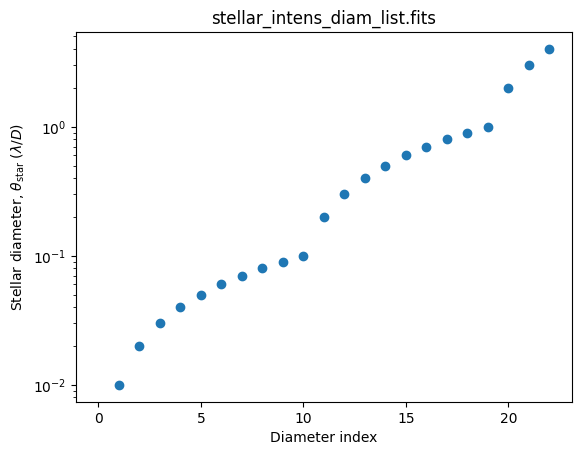

In [32]:
n_diams = len(stellar_intens_diam_list)
plt.scatter(np.arange(n_diams), stellar_intens_diam_list)
plt.yscale("log")
plt.xlabel("Diameter index")
plt.ylabel(r"Stellar diameter, $\theta_\text{star}$ ($\lambda/D$)")
plt.title("stellar_intens_diam_list.fits")
plt.show()

## The stellar intensity maps themselves
Lets take a close look at a single stellar intensity map $I(\theta_\text{star},x,y)$. In this case we'll choose the first one provided, which in this case is $\theta_\text{star}=0$.

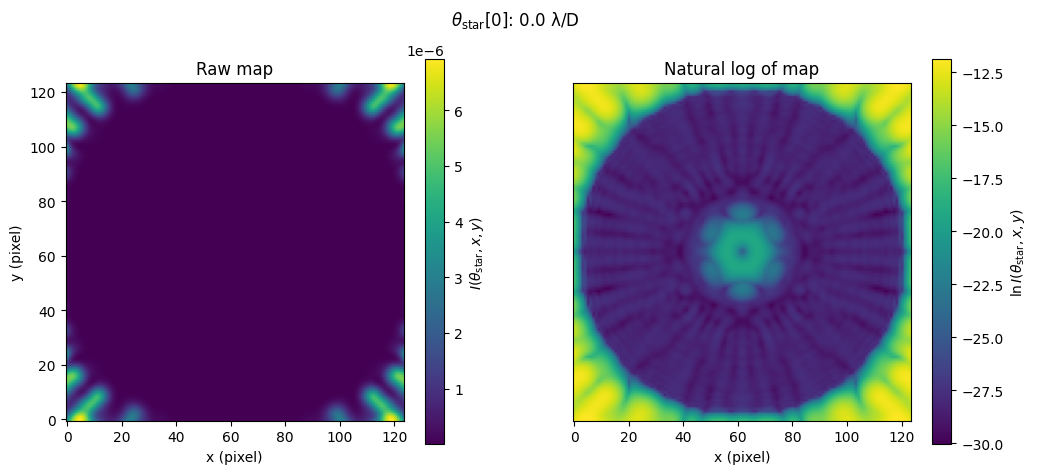

In [57]:
fig, (ax_abs, ax_log) = plt.subplots(ncols=2, figsize=(12, 5))
diam = 0
psf = stellar_intens_data[0]

# Plot the PSF data at the current offset
img_abs = ax_abs.imshow(psf, origin="lower")
img_log = ax_log.imshow(np.log(psf), origin="lower")

# Make the plot pretty
fig.suptitle(
    f"$\\theta_\\text{{star}}$[{diam}]: {stellar_intens_diam_list[diam]} {lod}"
)
ax_abs = ax_labels_and_ticks(ax_abs)
ax_log = ax_labels_and_ticks(ax_log)
ax_abs.set_title("Raw map")
ax_log.set_title("Natural log of map")
plt.colorbar(img_abs, ax=ax_abs, label=r"$I(\theta_\text{star},x,y)$")
plt.colorbar(img_log, ax=ax_log, label=r"$\ln{I(\theta_\text{star},x,y)}$")
plt.show()

### Cool plot! Now, what is it?

Thank you. The raw map for a single $\theta_\text{star}$ is a unitless 2d array that represents the stellar count rate for all pixels $(x,y)$ normalized by the total stellar count rate entering the coronagraph. The normalization is done to make these useful for observing scenarios with different stellar fluxes, bandpasses, throughputs, etc.

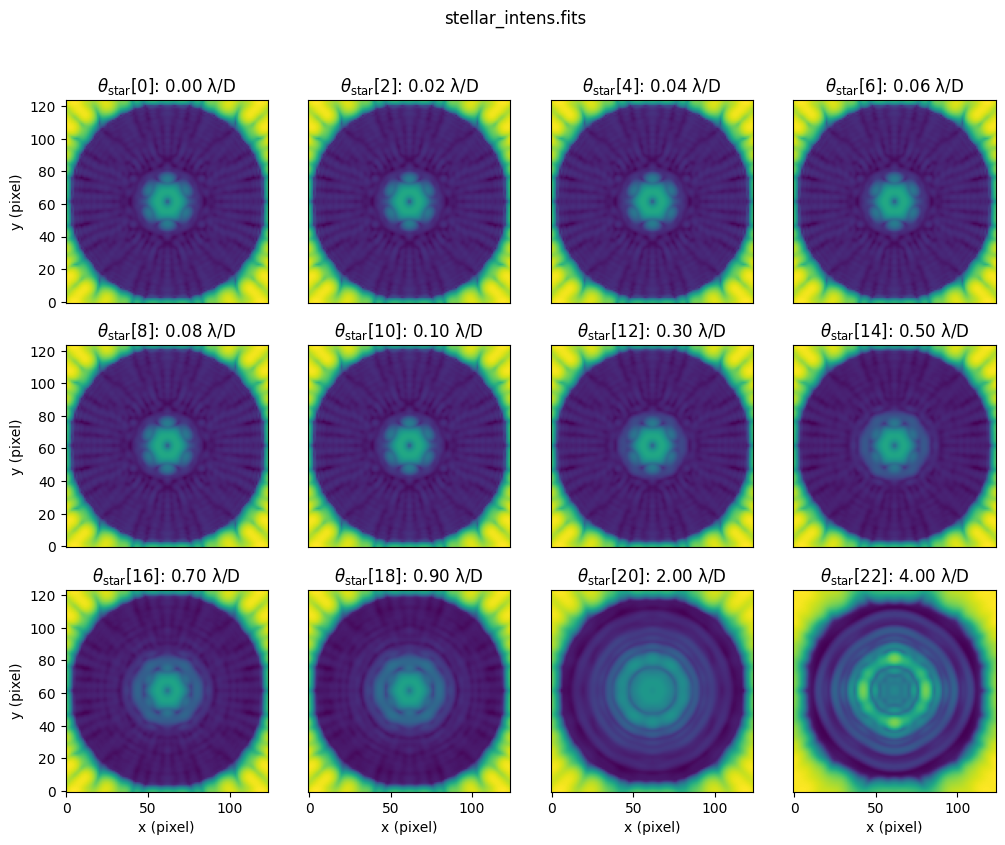

In [45]:
### Plotting PSF data
fig, axes = set_up_plot()

# Choosing the PSF offset index values
diams = np.linspace(0, n_diams - 1, axes.shape[0] * axes.shape[1], dtype=int)

# Loop through and plot the PSFs
for ax, diam in zip(axes.flatten(), diams):
    # Load the PSF from the provided data
    psf = stellar_intens_data[diam]

    # Plot the PSF data at the current offset
    ax.imshow(np.log(psf), origin="lower")

    # Make the plot pretty
    ax.set_title(
        f"$\\theta_\\text{{star}}$[{diam}]: {stellar_intens_diam_list[diam]:.2f} {lod}"
    )
    ax = ax_labels_and_ticks(ax)
plt.suptitle("stellar_intens.fits")
plt.show()

## Using yippy

When working with actual stars we want the ability to give an exact diameter instead of having to stick with one of the provided ones. To handle this we will use `yippy.stellar_intens`.

In [58]:
# yippy has a lot of logging messages, disabling to keep this documentation clean
import logging

from yippy import Coronagraph

yippy_logger = logging.getLogger("yippy")
yippy_logger.setLevel(logging.ERROR)

coro = Coronagraph(yip_path)

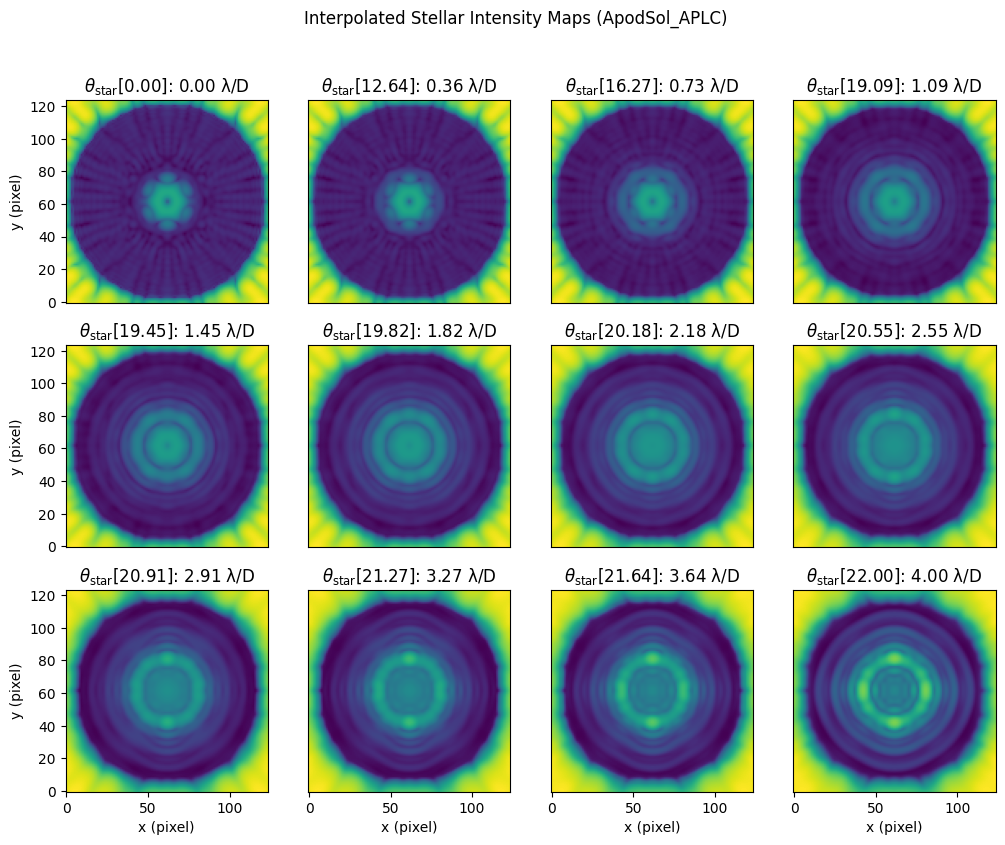

In [68]:
from scipy.interpolate import interp1d

### Plotting PSF data
fig, axes = set_up_plot()

# Choosing the PSF offset index values
n_plots = axes.shape[0] * axes.shape[1]

diams = np.linspace(0, max(stellar_intens_diam_list), n_plots) * lod
interp = interp1d(stellar_intens_diam_list, np.arange(len(stellar_intens_diam_list)))
# Loop through and plot the PSFs
for ax, diam in zip(axes.flatten(), diams):
    # USE YIPPY TO GENERATE THE INTENSITY MAP
    ######################
    intens_map = coro.stellar_intens(diam)
    ######################

    # Plot the PSF data at the current offset
    ax.imshow(np.log(intens_map), origin="lower")

    # Make the plot pretty
    ax.set_title(f"$\\theta_\\text{{star}}[{interp(diam):.2f}]$: {diam:.2f}")
    ax = ax_labels_and_ticks(ax)
fig.suptitle(f"yippy interpolated Stellar Intensity Maps ({coro.name})")
plt.show()